Veraltet, pre-OO rewrite

In [1]:
# Levenshtein distance is used as a metric of string distance. If not installed locally, uncomment and run the line below.
#%pip install levenshtein

# Todo

- matching über jahresgrenzen hinaus
- line merging prozess optimieren
- hierarchisieren der daten, seitenstruktur integrieren
- seperierungsversuche der unterdaten
- tests bauen, mit mehr daten machen

## Extraction of Lines and Their Coordinates

In [2]:
import re
import xml.etree.ElementTree as ET
import glob
import pprint
import logging


lines = [] # all the lines we will work on
pageMaxValues = {} # maximum / minimum coordinates for line positions on all pages
for file in sorted(glob.glob("xml_sources/*/*.xml")):
    tree = ET.parse(file)
    root = tree.getroot()
    textLines = root.findall('.//{*}TextLine')
    localPageMaxValues = pageMaxValues[file] = {} # coordinate information for lines on this specific page (i.e. XML document)
    for textLineElement in textLines:
        thisline = {}

        # reading coordinates
        coordsElement = textLineElement.find('./{*}Coords')
        coords = coordsElement.attrib["points"].split() # coordinates in "a,b" format as provided by PageXML
        xCoords = []
        yCoords = []
        for coord in coords:
            xCoords.append(int(coord.split(',')[0]))
            yCoords.append(int(coord.split(',')[1]))

        thisline["xMax"] = xBiggest = max(xCoords)
        thisline["xMin"] = xSmallest = min(xCoords)
        thisline["yMax"] = yBiggest = max(yCoords)
        thisline["yMin"] = ySmallest = min(yCoords)
        thisline["width"] = thisline['xMax'] - thisline['xMin']
        thisline["height"] = thisline['yMax'] - thisline['yMin']
        thisline['filename'] = file
        datePattern = r'(?<=xml_sources/)\d+(?=/)'
        thisline["year"] = re.search(datePattern, file).group(0)


        # amending the page coordinate values if applicable
        if "xMax" not in localPageMaxValues or localPageMaxValues['xMax'] < xBiggest:
            localPageMaxValues['xMax'] = xBiggest
        if "xMin" not in localPageMaxValues or localPageMaxValues['xMin'] > xSmallest:
            localPageMaxValues['xMin'] = xSmallest
        if "yMax" not in localPageMaxValues or localPageMaxValues['yMax'] < yBiggest:
            localPageMaxValues['yMax'] = yBiggest
        if "yMin" not in localPageMaxValues or localPageMaxValues['yMin'] > ySmallest:
            localPageMaxValues['yMin'] = ySmallest

        textEquivElement = textLineElement.find('./{*}TextEquiv/{*}Unicode')
        thisline["text"] = textEquivElement.text
        lines.append(thisline)

        logging.info(f"New line with coordinates {coords}, x coordinates {xCoords} and y coordinates {yCoords}\nx: {xSmallest} y: {ySmallest} bis\nx: {xBiggest} y: {yBiggest}\nText: {thisline['text']} generated")
    logging.info(f"x: {localPageMaxValues['xMin']} y: {localPageMaxValues['yMin']} to\nx: {localPageMaxValues['xMax']} y: {localPageMaxValues['yMax']}")

pprint.pprint(pageMaxValues)

{'xml_sources/0025_057003551598_00000025.xml': {'xMax': 1478,
                                                'xMin': 181,
                                                'yMax': 2271,
                                                'yMin': 201},
 'xml_sources/0026_057003551598_00000026.xml': {'xMax': 1415,
                                                'xMin': 113,
                                                'yMax': 2281,
                                                'yMin': 161},
 'xml_sources/0027_057003551598_00000027.xml': {'xMax': 1466,
                                                'xMin': 164,
                                                'yMax': 2274,
                                                'yMin': 175},
 'xml_sources/0028_057003551598_00000028.xml': {'xMax': 1437,
                                                'xMin': 131,
                                                'yMax': 2195,
                                                'yMin': 113},
 'xml_source

## Classifying Lines

In [3]:
SINGLE_INDENT_REL = 0.1 # relative to effective page width
DOUBLE_INDENT_REL = 0.2 # relative to effective page width
X_TOLERANCE_EDGE = 100 # absolute

# when determining if two seperate lines shoud be merged together as one, the following distance measurements should be used
X_TOLERANCE_FOR_SINGLE_LINE = 20
Y_TOLERANCE_FOR_SINGLE_LINE = 70

KEYWORDS = ["Mitglied", "Vorstand", "Direktor", "stellvertr", "Aufsichtsrat", "Vorsitz", "Präsident", "Geschäftsführer"]

previousLine = None
runningAgain = False # is this a repeat loop run after having pasted further information from other lines into a line?

i = 0
while i < len(lines):
    line = lines[i] # this for-loop design is required so we run an element twice
    if (i != 0) and not (lines[i-1]["type"] == "ignore" or lines[i-1]["type"] == "company_cont"):
            previousLine = lines[i-1]
    localPageMaxValues = pageMaxValues[line["filename"]]
    
    xOffsetLeft = abs(line["xMin"] - localPageMaxValues["xMin"])
    xOffsetRight = abs(line["xMax"] - localPageMaxValues["xMax"])
    pageWidth = localPageMaxValues["xMax"] - localPageMaxValues["xMin"]

    if previousLine:
        xDistanzRechts = abs(int(previousLine["xMax"]) - int(line["xMin"]))
        xDistanzLinks = abs(int(previousLine["xMin"]) - int(line["xMax"]))
        yDistanz = abs(int((int(previousLine["yMax"]) - int(line["yMax"]) + int(previousLine["yMin"]) - int(line["yMin"])) / 2)) # in order to minimize false positives when looking at the height difference between two lines, the y distance is measured by the average of the distance between their respective highest and lowest points
    if previousLine and xDistanzRechts < Y_TOLERANCE_FOR_SINGLE_LINE and yDistanz < X_TOLERANCE_FOR_SINGLE_LINE and not runningAgain: # the current line is to be associated with the line before; therefore we add its contents there and set it to be ignored in the further process
        previousLine["text"] += " " + line["text"]
        line["type"] = "ignore"
        runningAgain = False
    elif previousLine and xDistanzLinks < Y_TOLERANCE_FOR_SINGLE_LINE and yDistanz < X_TOLERANCE_FOR_SINGLE_LINE and not runningAgain: # the previous line is to be associated with the curent one; therefore we add its contents there and set it to be ignored in the further process. This constitutes a reading order of the lines from right to left; this sometimes happens because the line on the right is a bit higher.
        line["text"] += " " + previousLine["text"]
        previousLine["type"] = "ignore"
        line["type"] = "RUNNING AGAIN"
        runningAgain = True
    elif xOffsetLeft < X_TOLERANCE_EDGE: # The line is left-aligned
        line["type"] = "name"
        runningAgain = False
    elif xOffsetLeft < SINGLE_INDENT_REL * pageWidth: # The line is indented once -> The type is "company"
        line["type"] = "company"
        runningAgain = False
    elif xOffsetLeft < DOUBLE_INDENT_REL * pageWidth and xOffsetRight > X_TOLERANCE_EDGE: # The line is indented twice and not right-aligned. We have to exclude right-alignedness because some right-aligned addresss are long enough to start at the point of double indentation. Double alignment means that this is either a position description or a continuation of a company name
        if any(keyword.lower() in line["text"].lower() for keyword in KEYWORDS):
            line["type"] = "position"
        else:
            line["type"] = "company_cont"
            previousLine["text"] += " " + line["text"]
        runningAgain = False
    elif xOffsetRight < X_TOLERANCE_EDGE: # The line is right aligned -> It is an address
        line["type"] = "address"
        runningAgain = False
    else:
        line["type"] = "unclear" # No type could be determined. TODO this is currently usually the case for page numbers. Unclear data will be associated to the person before. Create an extra classification for page numbers
        runningAgain = False
    logging.info(f'{line["text"]}\nhas type\n{line["type"]}\n')

    if runningAgain:
        logging.debug(f'{line["text"]} \nis now running again')
        i-=1 # we will examine the same line again and classify it; this is done when additional text from another line is pasted into it
    
    i+= 1 # end of loop

for i in range(len(lines)):
    logging.info("\n\nFinal line output")
    line = lines[i]
    logging.info(f'{line["text"]} \n{line["type"]}\n')

## Error Correction, Line Mending And Data Processing

In [4]:
from Levenshtein import distance
from pprint import pprint

MAX_LEVENSHTEIN_DISTANCE = 3 # Levenshtein distance describes the number of characters that have to be changed to turn one string into another. Example: abcd and abba have a Levenshtein distance of two as there are two changes needed (abcd -> abbd -> abba). This is used here as a means of error correction so that company names that, due to the OCR or a varying spelling in the original source, refer to the same company but are not transkribed exactly the same can still be grouped together. TODO evaluate whether this should be a relative value to the string lenght, rather than an absolute allowed max amount.
persons = {}
companies = []

previousPerson = None # this is the name of the last noted person. Until another name comes up, all records will be associated with this person.
previousRelation = None # this is conceptually the same, but refers to relations of persons to businesses, such as whether they are on the board.

lastWasAddress = False # sometimes addresss get read in the line before the person itself does; in this case we need to be able to retroatively still group the address to the right person.
theAddressBefore = ""
addressBacklock = None
tempAddress = None

for line in lines:
    if line["type"] == "name": # the line is a person's name (and occupation)
        if lastWasAddress: # retrofitting the address read in the line before to this person
            lastWasAddress = False
            addressBacklock = persons[previousPerson]["address"]
            persons[previousPerson]["address"] = theAddressBefore
            theAddressBefore = ""
        previousPerson = line["text"]
        persons[previousPerson] = {}
        if addressBacklock is not None: # TODO make the address retrofitting logic more intuitive and require less complexity in other parts of the logic
            persons[previousPerson]["address"] = addressBacklock
        addressBacklock = None
        previousRelation = None # reset is needed to disambiguate relations to continuations of the name on a second line as they both have the same indentation level
    elif previousPerson and line["type"] == "address":
        if "address" in persons[previousPerson]: # an address already exists in this person's record, likely indicating that this address will have to retrofitted somewhere else
            # we save and then replace the old address in case we need it again later
            lastWasAddress = True
            theAddressBefore = persons[previousPerson]["address"]
            persons[previousPerson]["address"] = line["text"]
        else:
            persons[previousPerson]["address"] = line["text"]
    elif previousPerson and line["type"] == "position":
        if not line["text"] in persons[previousPerson]:
            lastWasAddress = False
            persons[previousPerson][line["text"]] = [] # all jobs that fall under this relation will be added to the list indexed under its name
            previousRelation = line["text"] # we save the relation so it can be referenced by the companies following it
    elif previousPerson and line["type"] == "company":
        match = None
        if line["text"] not in companies:
            for firma in companies:
                if distance(firma, line["text"]) < MAX_LEVENSHTEIN_DISTANCE: # checking if there is a related company name that this entry should be matched to instead of creating its own new one
                    logging.info(f"Presumed match of two differently named companies found: {line['text']} and {firma}")
                    line['text'] = firma # TODO we primitively adjust all presumed faulty company names to the first recorded occurance; however, this can be just as wrong. It would be better to set a flag for a potential naming conflict and later resolve to the most occuring variant of the name.
                    match = True
                    break
            if not match:
                companies.append(line["text"])
            lastWasAddress = False
        if previousRelation is None: # not a company but a continuation of the name
            logging.debug(f"\nThe record of a person had to be removed in order to incorporate the name spanning multiple lines. The record is as follows. If it contains records of companies, please revisit the matching algorithm at this point. {persons[previousPerson]}")
            if persons[previousPerson] != {}:
                logging.warning("The record was not empty, please revisit the matching algorithm")
            persons.pop(previousPerson)
            previousPerson += " " + line["text"]
            persons[previousPerson] = {} # new initialisation with new name
        else:
            persons[previousPerson][previousRelation].append(line["text"])
        lastWasAddress = False
    elif line["type"] == "company_cont":
        logging.info(f'\nThe textline \"\n{line["text"]}\n\" with the associated type {line["type"]} is purposefully ignored, as it was already grouped to another line')
        lastWasAddress = False
    elif line["type"] == "ignore":
        logging.info(f'\nThe textline \"\n{line["text"]}\n\" with the associated type {line["type"]} is purposefully ignored, as it was already grouped to another line')
        lastWasAddress = False
    else:
        logging.info(f'\nThe textline \"\n{line["text"]}\n\" with the associated type {line["type"]} could not be clearly classified as a certain type. It will be attempted to group it to the last read person under a special field.')
        if previousPerson:
            if not "unclear" in persons[previousPerson]:
                persons[previousPerson]["unclear"] = []
            persons[previousPerson]["unclear"].append(line["text"])
        else:
            logging.warning(f'\nThe textline \"\n{line["text"]}\n\" with the associated type {line["type"]} could not be clearly classified as a certain type. No preceding person was found to group it to, so the record is lost.')
        lastWasAddress = False

print("\n\n")
pprint(persons, width=200)
print(len(persons))

The textline "
Bremer Wollwäscherei, Bremen.
" with the associated type company could not be clearly classified as a certain type. No preceding person was found to group it to, so the record is lost.
The textline "
Deutsche Toggesellschaft, Berlin.
" with the associated type company could not be clearly classified as a certain type. No preceding person was found to group it to, so the record is lost.
The textline "
Deutsche Versicherungs-Gesellschaft, Bremen.
" with the associated type company could not be clearly classified as a certain type. No preceding person was found to group it to, so the record is lost.
The textline "
Mitglied des Aufsichtsrats d.
" with the associated type position could not be clearly classified as a certain type. No preceding person was found to group it to, so the record is lost.
The textline "
Assecuranz Compagnie Hansa, Bremen.
" with the associated type company could not be clearly classified as a certain type. No preceding person was found to group it t




{'Achelis, Fritz,': {'Mitglied des Aufsichtsrats d.': ['Hermes Aktiengesellschaft, Bremen.'],
                     'address': 'Am Dobben 25, Bremen.',
                     'stellvertr. Vorsitzender des Aufsichtsrats d.': ['Deutsche Cement-Industrie A.-G., Bremen.']},
 'Achenbach, August': {'Mitglied des Aufsichtsrats d.': ['Schieferwerke Ausdauer Aktien-Gesellschaft, Probstzella.'], 'address': 'Betzdorf, Kr. Altenkirchen, Westerw.'},
 'Achenbach, Fritz': {'Mitglied des Aufsichtsrats d.': ['Schieferwerke Ausdauer Aktien-Gesellschaft, Probstzella.'], 'address': 'Weidenau, Sieg.'},
 'Achter, Wilhelm, Generaldirektor,': {'Mitglied des Aufsichtsrats d.': ['W. Heymann Aktien-Gesellschaft, Inden.', 'Schorch-Werke A.-G., Rheydt.'],
                                       'Vorstand d.': ['Gladbacher Woll-Industrie Aktiengesellschaft vorm. L. Josten'],
                                       'address': 'Nordstr. 7, M.-Gladbach.'},
 'Achterberg, Otto, Bankvorstand.': {'Vorstand d.': ['Kur- und N

# Network Population

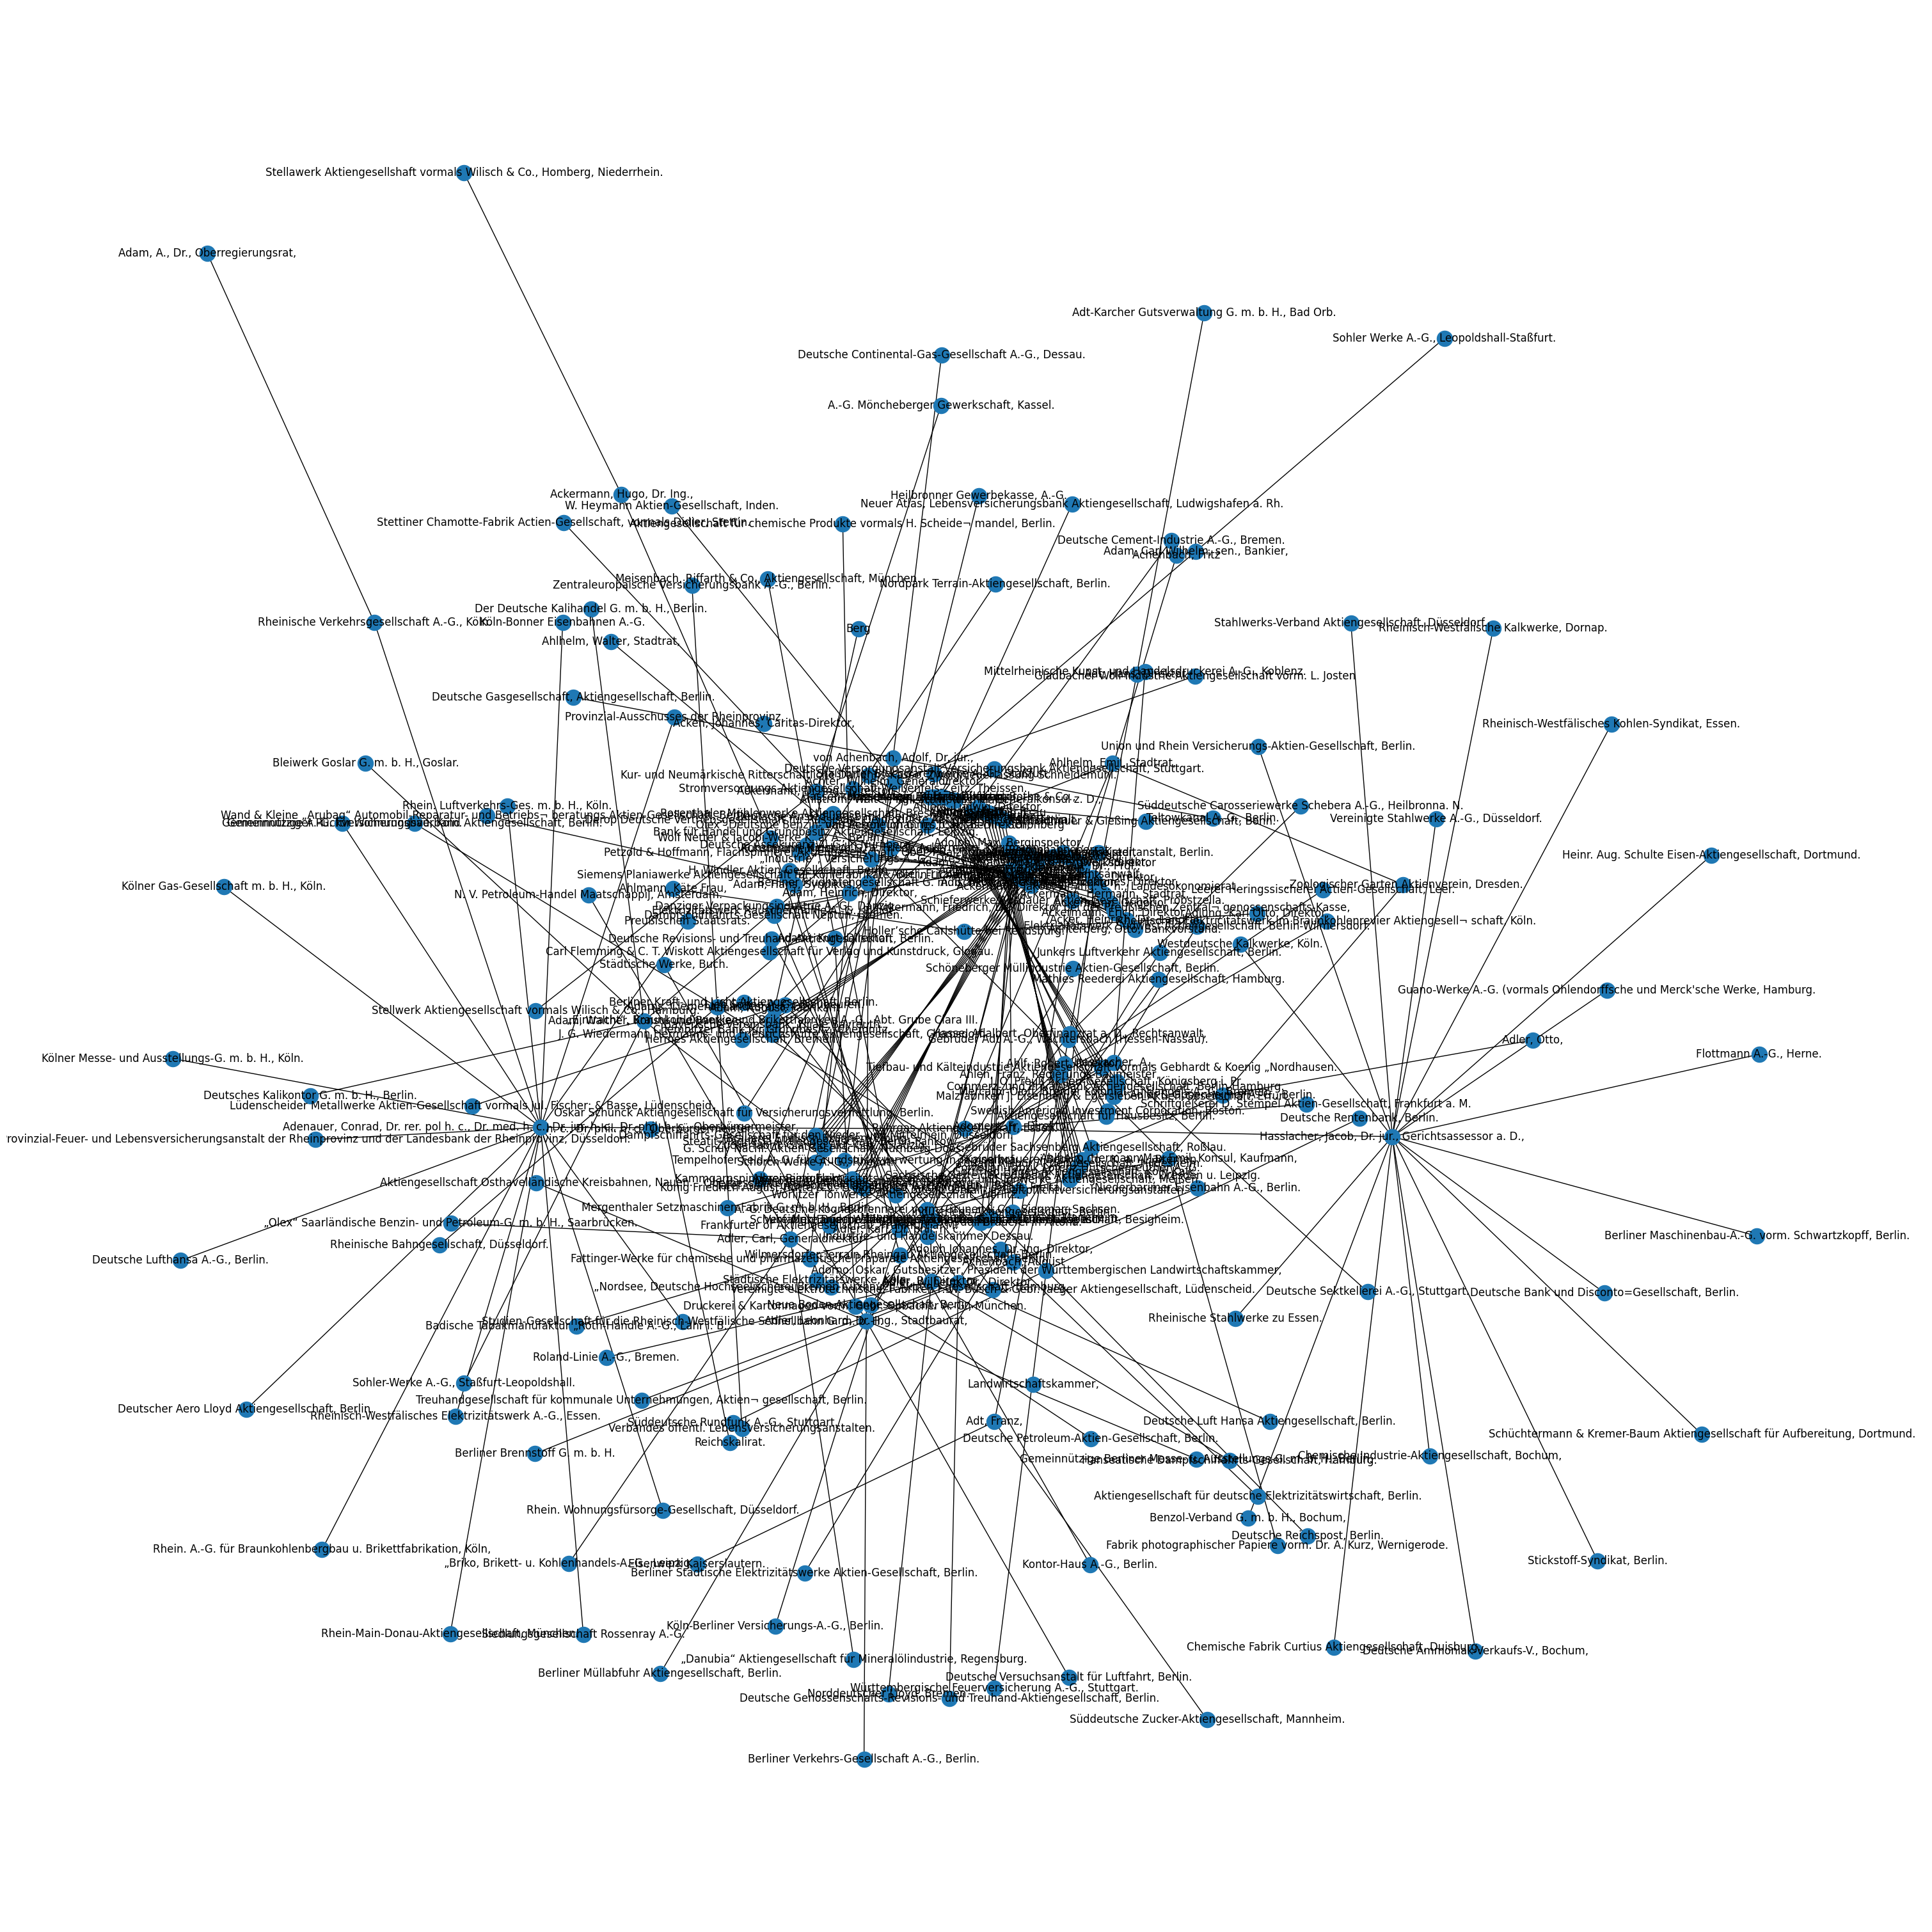

In [5]:
import networkx as nx
YEAR = 1932

G = nx.Graph()
G.clear() # Nodebook cell can be rerun at will

# csv file headers
personCSV = [["person name","address","year"]]
companiesCSV = [["company name","year"]]
amCSV = [["person","relationship","company","year"]]

for person in list(persons.keys()):
    if "address" in persons[person]:
        address = persons[person]["address"]
    else:
         address = ""
    G.add_node(person,
        nodeType="person",
        year=YEAR,
        address=address)
    personCSV.append([person,address,YEAR])
    
for company in companies:
    G.add_node(company,
        nodeType="company",
        year=YEAR)
    companiesCSV.append([company,YEAR])

for person in list(persons.keys()):
    for relationship in persons[person]:
        if relationship != "address" and relationship != "unclear":
            for company in persons[person][relationship]:
                G.add_edge(person,
                           company,
                           jahr=YEAR)
                amCSV.append([person,relationship,company,YEAR])

# example visualisation
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 30))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

# Network Export

In [6]:
import os
nx.write_gexf(G, "./partial_32.gexf")

def improvizedCSVWriter(array, outputfile):
    try:
        os.remove(outputfile)
    except:
        pass
    with open(outputfile, 'w', encoding="utf-8-sig") as f:
        for cell in array:
            result = ""
            for item in cell:
                result += '"' + str(item).replace('"', "''") + '",'
            f.write(result + "\n")
            print(result)

improvizedCSVWriter(personCSV, "persons.csv")
improvizedCSVWriter(companiesCSV, "companies.csv")
improvizedCSVWriter(amCSV, "am.csv")

"person name","address","year",
"Achelis, Fritz,","Am Dobben 25, Bremen.","1932",
"von Achenbach, Adolf, Dr. jur.,","Kaiserstr. 31, Neubabelsberg.","1932",
"Achenbach, August","Betzdorf, Kr. Altenkirchen, Westerw.","1932",
"Achenbach, Fritz","Weidenau, Sieg.","1932",
"Achter, Wilhelm, Generaldirektor,","Nordstr. 7, M.-Gladbach.","1932",
"Achterberg, Otto, Bankvorstand.","Neuer Markt 14, Schneidemühl.","1932",
"van Acken, Johannes, Caritas-Direktor,","Köln.","1932",
"Acker, Heinrich, Dr., Landrat,","Elsterstr. 4, Zeitz.","1932",
"Ackermann, Dr.-Ing., Direktor,","Bahnhofstr. 42, Bonn a. Rh.","1932",
"Ackermann, Erich, Direktor,","Breslau-Rosenthal.","1932",
"Ackermann, Friedrich, Dr., Direktor bei der Preußischen Zentral¬ genossenschafts-Kasse,","Steglitzer Str. 34, Berlin-Lichterfelde.","1932",
"Ackermann, Grigorio,","Budapester Str. 9, Berlin W 62.","1932",
"Ackermann, Heinrich i. Fa. Friedr. Ackermann, Kaufmann,","","1932",
"Ackermann, Hermann, Stadtrat,","Leipzig.","1932",
"Ackermann